In [1]:
import matplotlib.pyplot as plt
import numpy as np


import pandas as pd
import seaborn as sns


from mimic.data_imputation.impute_GP import GPImputer
from mimic.model_infer.infer_VAR_bayes import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
metabolites = pd.read_csv(r'Source Data/fig4.tsv', delimiter='\t')

In [3]:
# Letr's create 2 dataframes, one for the L1rel_MP and the other for the L1rel_MT data, using the date, L1 and L2tel values

dataL1_MP = metabolites[['date', 'L1', 'L1rel_MP']]

dataL1_MT = metabolites[['date', 'L1', 'L1rel_MT']]
dataL1_MP.head(15)

,date,L1,L1rel_MP
0,2011-03-21,01_Fermentation,0.096899
1,2011-03-21,02_Homoacetogenesis,0.009890
2,2011-03-21,03_Superpathway of thiosulfate metabolism (Des...,0.000579
3,2011-03-21,"04_Utililization of sugar, conversion of pento...",0.000535
4,2011-03-21,05_Fatty acid oxidation,0.025483
5,2011-03-21,06_Amino acid utilization biosynthesis metabolism,0.122784
6,2011-03-21,07_Nucleic acid metabolism,0.119531
7,2011-03-21,08_Hydrocarbon degradation,0.005524
8,2011-03-21,09_Carbohydrate Active enzyme - CAZy,0.003921
9,2011-03-21,10_TCA cycle,0.045398


c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


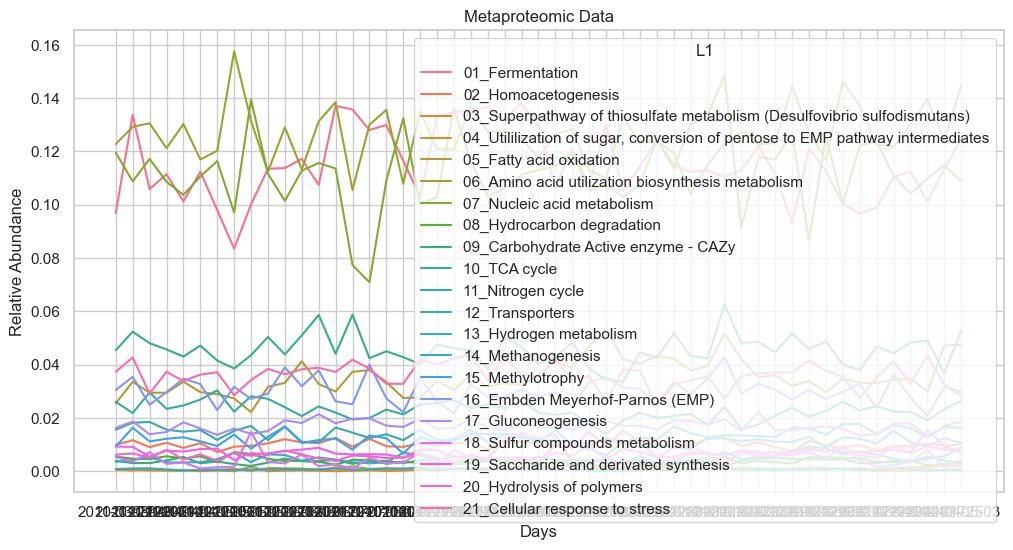

In [4]:
# Now let's visualize the data

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='L1rel_MP', hue='L1', data=dataL1_MP)
plt.title('Metaproteomic Data')
plt.xlabel('Days')
plt.ylabel('Relative Abundance')
plt.show()

c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


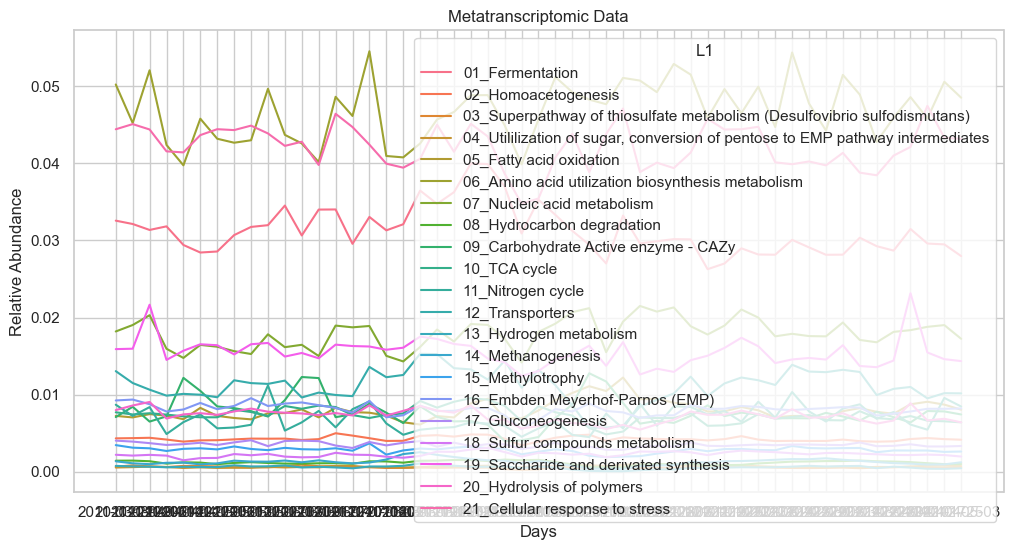

In [5]:
# Same for the metatranscriptomic data

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='L1rel_MT', hue='L1', data=dataL1_MT)
plt.title('Metatranscriptomic Data')
plt.xlabel('Days')
plt.ylabel('Relative Abundance')
plt.show()

In [6]:
# And do the same as we did for the MG and MT data sets

# Rename Nan in the L1 column to 'Other'

dataL1_MP['L1'] = dataL1_MP['L1'].replace(np.nan, 'Other')

# Change relative Date columns to days
dataL1_MP['date'] = pd.to_datetime(dataL1_MP['date'])
dataL1_MP['date'] = (dataL1_MP['date'] - dataL1_MP['date'].min()).dt.days

# Change the 'L1' column to a categorical column
dataL1_MP['L1'] = dataL1_MP['L1'].astype('category')

C:\Users\User\AppData\Local\Temp\ipykernel_30940\300627487.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataL1_MP['L1'] = dataL1_MP['L1'].replace(np.nan, 'Other')
C:\Users\User\AppData\Local\Temp\ipykernel_30940\300627487.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataL1_MP['date'] = pd.to_datetime(dataL1_MP['date'])
C:\Users\User\AppData\Local\Temp\ipykernel_30940\300627487.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

C:\Users\User\AppData\Local\Temp\ipykernel_30940\4211173979.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataL1_MT['L1'] = dataL1_MT['L1'].replace(np.nan, 'Other')
C:\Users\User\AppData\Local\Temp\ipykernel_30940\4211173979.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataL1_MT['date'] = pd.to_datetime(dataL1_MT['date'])
C:\Users\User\AppData\Local\Temp\ipykernel_30940\4211173979.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

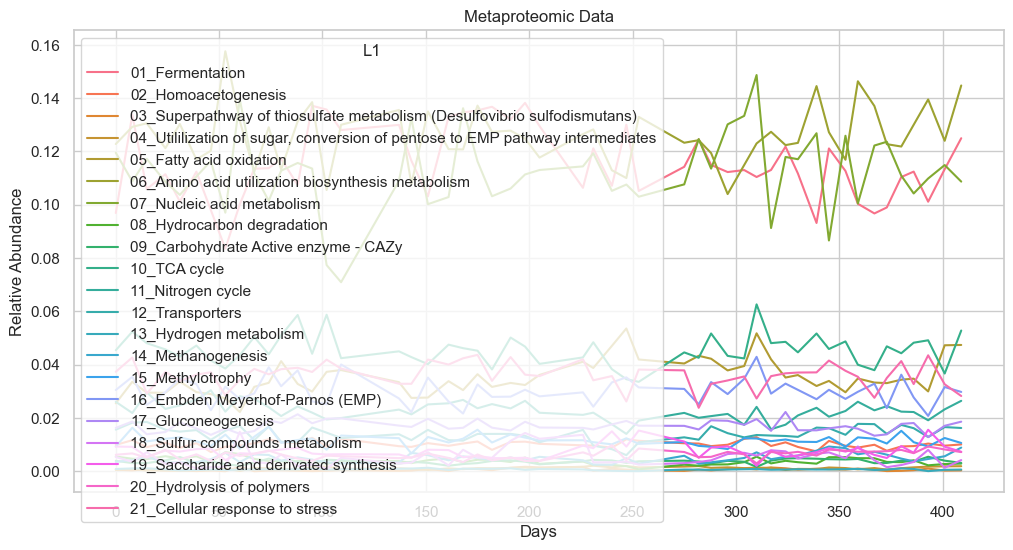

In [7]:
# do the same for the L1rel_MT data set

# Rename Nan in the L1 column to 'Other'

dataL1_MT['L1'] = dataL1_MT['L1'].replace(np.nan, 'Other')

# Change relative Date columns to days
dataL1_MT['date'] = pd.to_datetime(dataL1_MT['date'])
dataL1_MT['date'] = (dataL1_MT['date'] - dataL1_MT['date'].min()).dt.days

# Change the 'L1' column to a categorical column
dataL1_MT['L1'] = dataL1_MT['L1'].astype('category')

# Plot the data, relative abundance (value) vs. days (date) for each L1


sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='L1rel_MP', hue='L1', data=dataL1_MP)
plt.title('Metaproteomic Data')
plt.xlabel('Days')
plt.ylabel('Relative Abundance')
plt.show()

In [8]:
# And now pivot the data so each 'L1' is a column for each data set

dataL1_MP_pivot = dataL1_MP.pivot(
    index='date', columns='L1', values='L1rel_MP').fillna(0)

dataL1_MT_pivot = dataL1_MT.pivot(
    index='date', columns='L1', values='L1rel_MT').fillna(0)

In [9]:
# Step 1: Determine the minimum and maximum index
min_index = dataL1_MP_pivot.index.min()
max_index = dataL1_MP_pivot.index.max()

# Step 2: Create a new index range from min_index to max_index
new_index = range(int(min_index), int(max_index) +
                  1)  # Ensure it's an integer range

# Step 3: Re-index the DataFrame
dataL1_MP_complete = dataL1_MP_pivot.reindex(new_index)

dataL1_MP_complete.head(15)

L1,01_Fermentation,02_Homoacetogenesis,03_Superpathway of thiosulfate metabolism (Desulfovibrio sulfodismutans),"04_Utililization of sugar, conversion of pentose to EMP pathway intermediates",05_Fatty acid oxidation,06_Amino acid utilization biosynthesis metabolism,07_Nucleic acid metabolism,08_Hydrocarbon degradation,09_Carbohydrate Active enzyme - CAZy,10_TCA cycle,...,12_Transporters,13_Hydrogen metabolism,14_Methanogenesis,15_Methylotrophy,16_Embden Meyerhof-Parnos (EMP),17_Gluconeogenesis,18_Sulfur compounds metabolism,19_Saccharide and derivated synthesis,20_Hydrolysis of polymers,21_Cellular response to stress
date,,,,,,,,,,,,,,,,,,,,,
0,0.096899,0.009890,0.000579,0.000535,0.025483,0.122784,0.119531,0.005524,0.003921,0.045398,...,0.015593,0.000846,0.003520,0.009267,0.030473,0.016261,0.005346,0.009267,0.006193,0.037334
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.133734,0.011645,0.000340,0.000870,0.033575,0.129235,0.108779,0.004688,0.003063,0.052367,...,0.018224,0.001059,0.004159,0.016334,0.035428,0.018678,0.003592,0.009150,0.006692,0.042688


In [10]:
# Reset the index
complete_dataMP_reset = dataL1_MP_complete.reset_index()

# Make index as float
complete_dataMP_reset['date'] = complete_dataMP_reset['date'].astype(float)

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -284.7949376739953


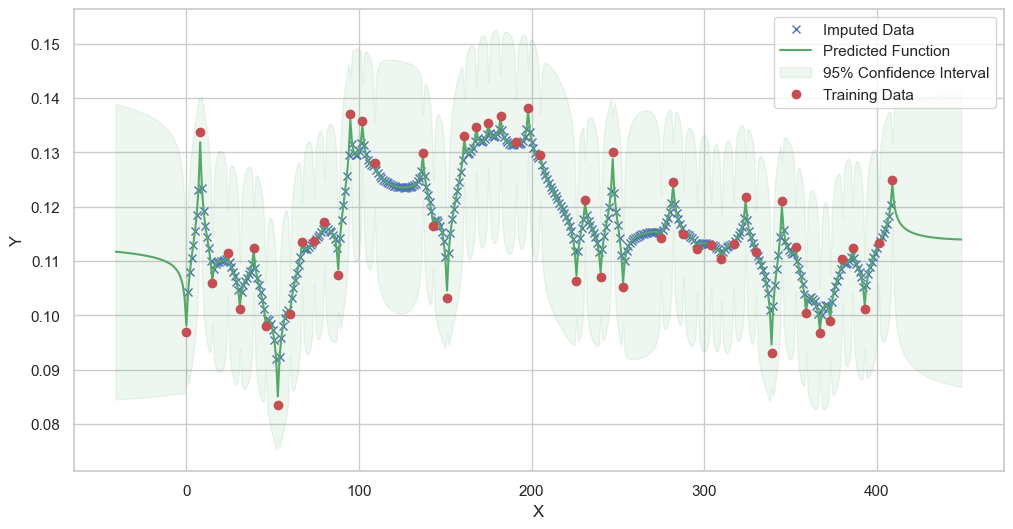

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern52'>
BIC: -516.3997882553258


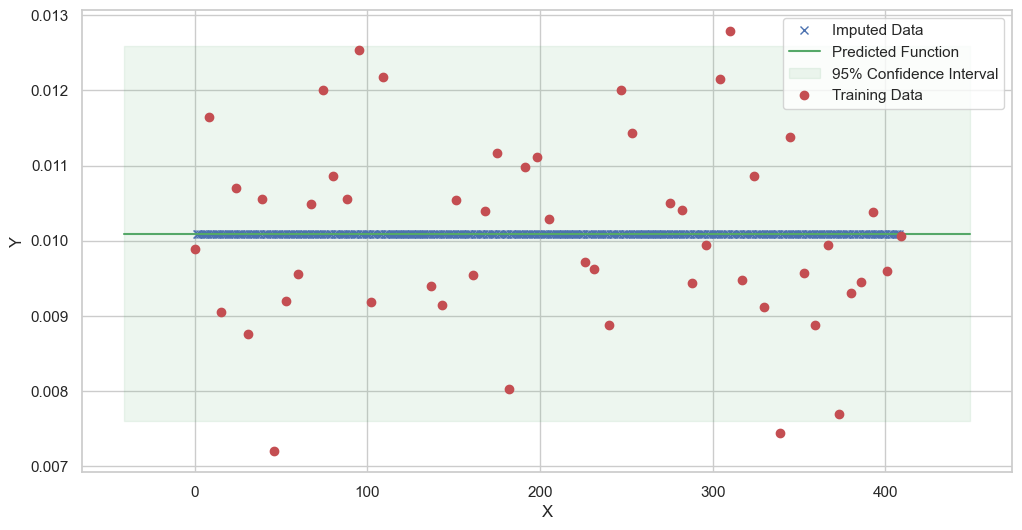

Model: GPR
Best kernel: <class 'gpflow.kernels.linears.Linear'>
BIC: -586.3618808386228


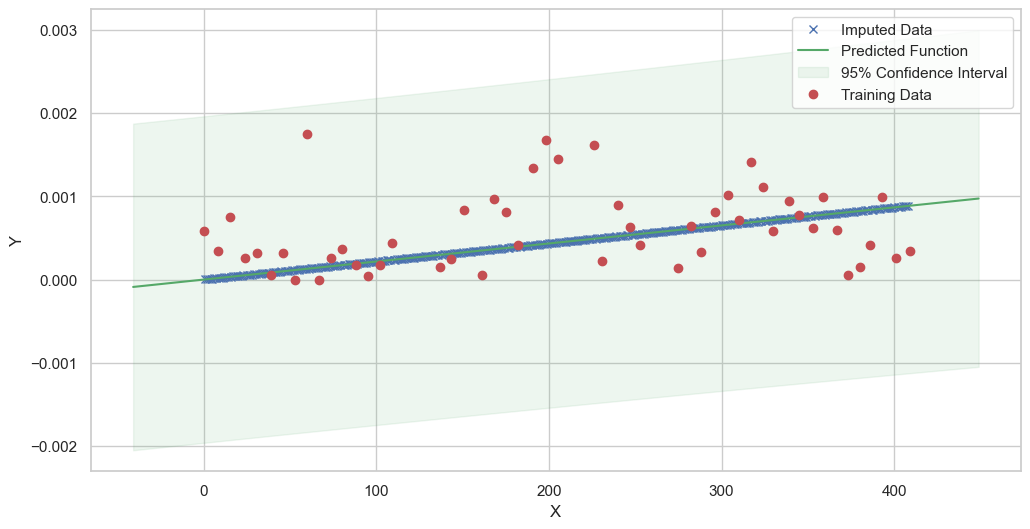

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Cosine'>
BIC: -583.0225376250065


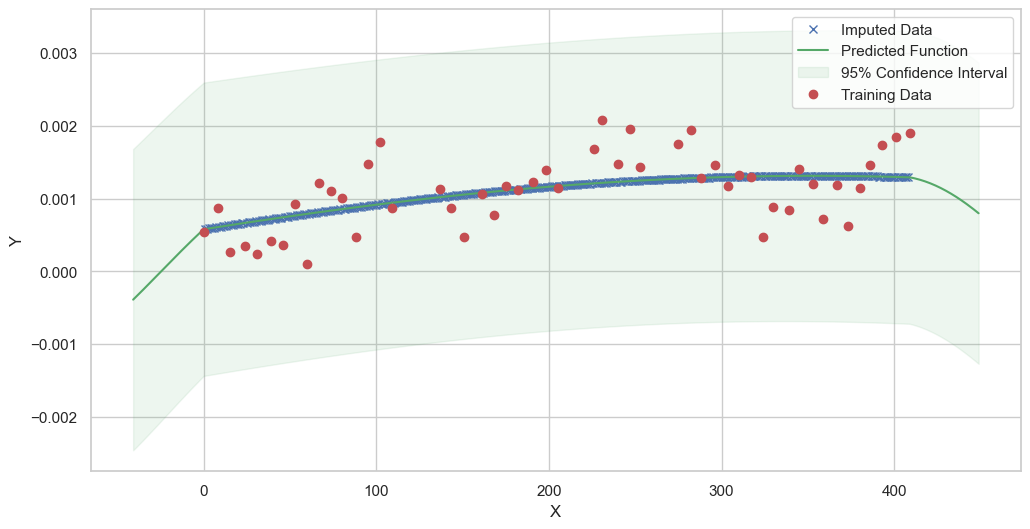

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -370.3251576289375


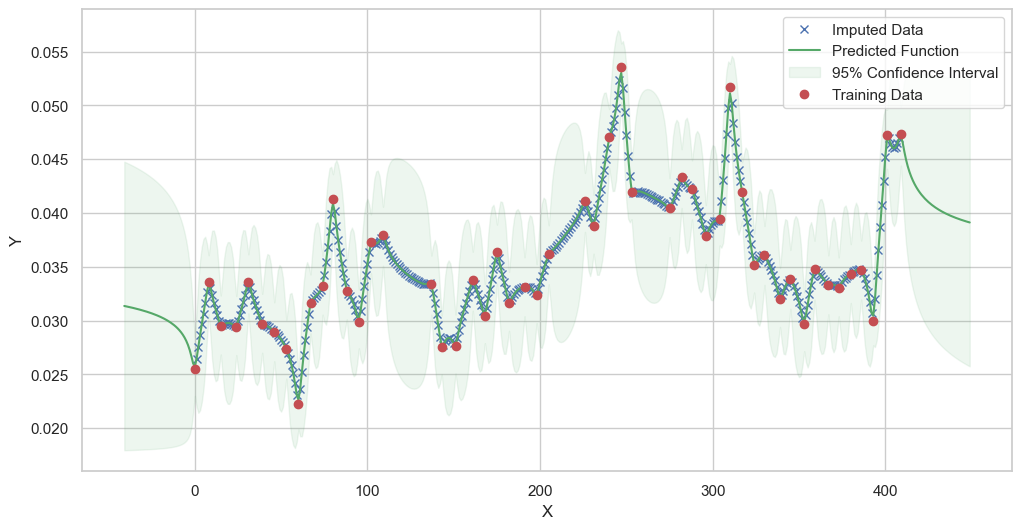

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern52'>
BIC: -297.8637805455072


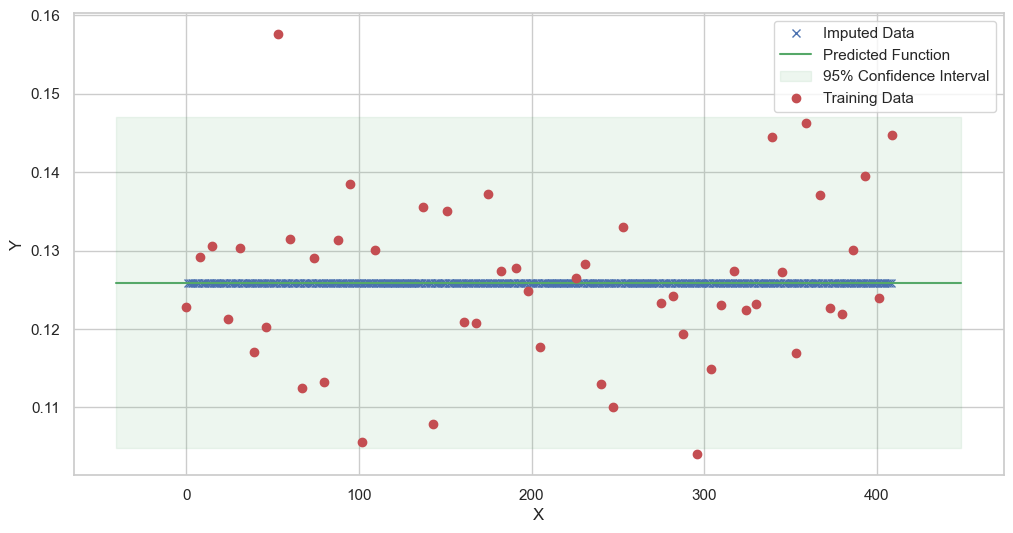

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern32'>
BIC: -269.37107846624474


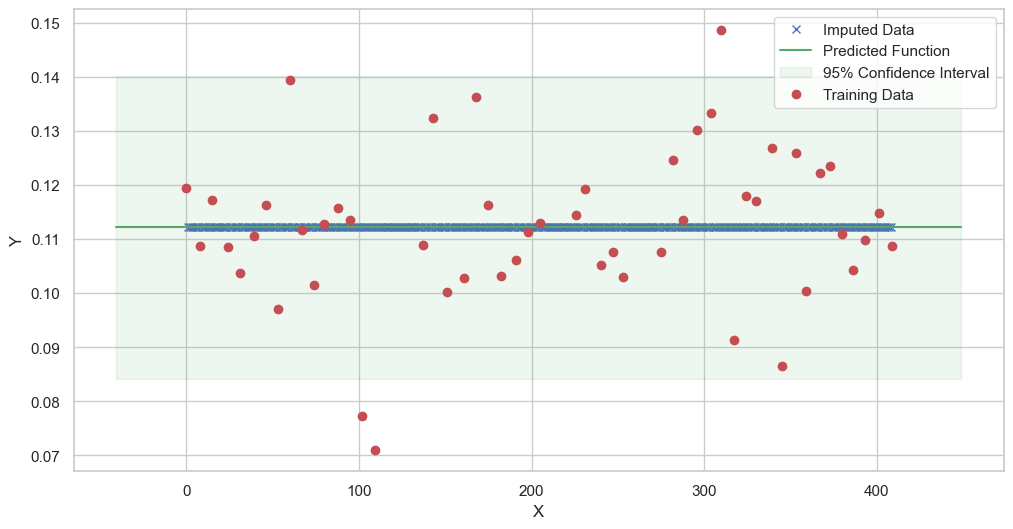

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern12'>
BIC: -535.3855591555472


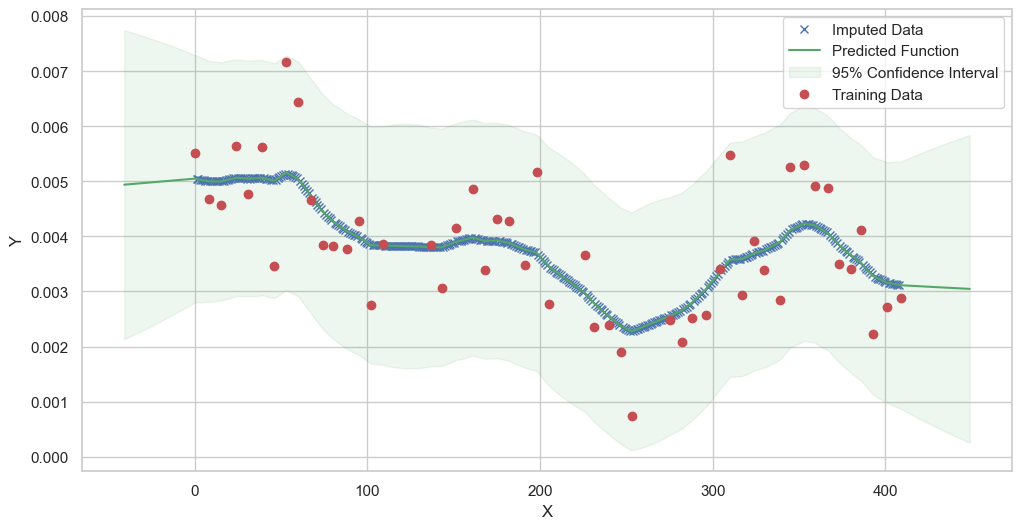

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern32'>
BIC: -558.2345595172367


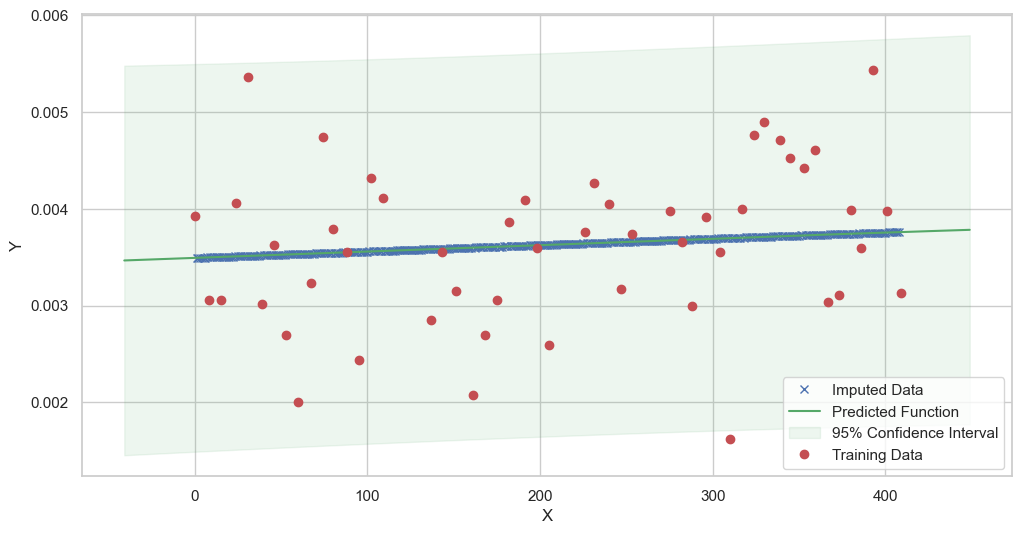

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern32'>
BIC: -360.62349619240706


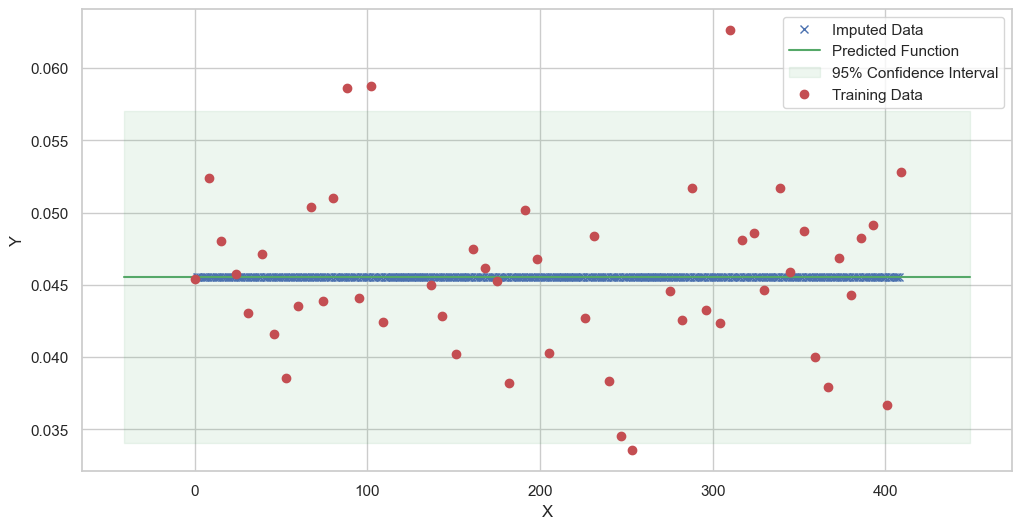

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -427.3629736358351


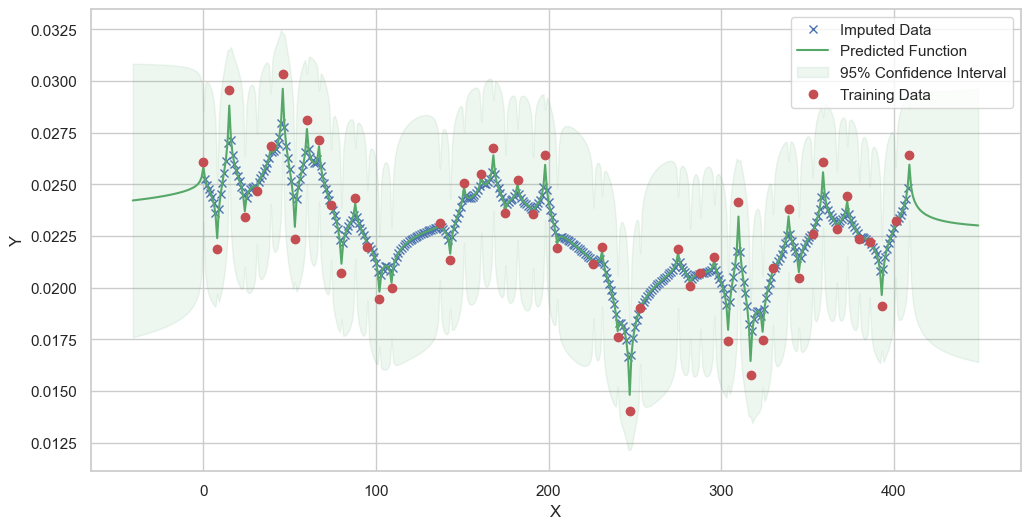

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern32'>
BIC: -452.0997825259693


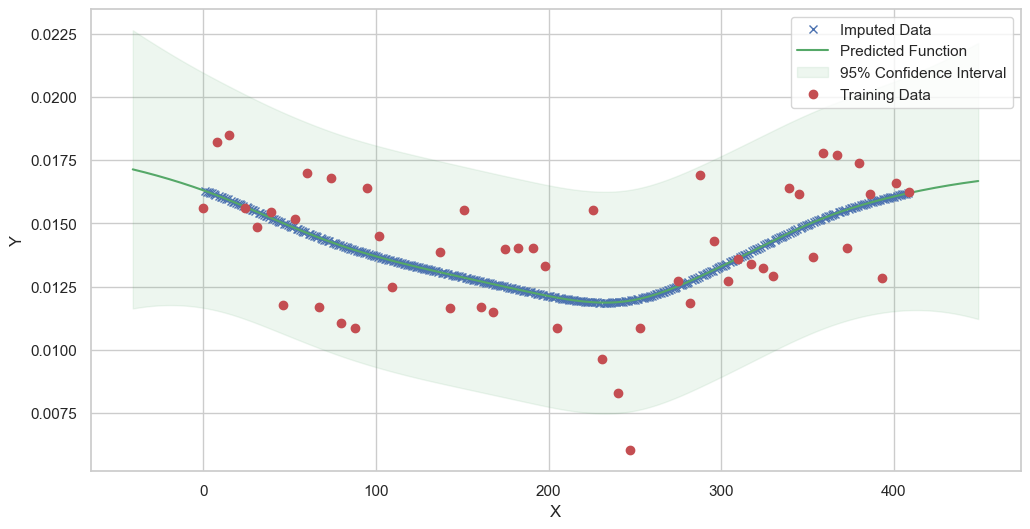

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Cosine'>
BIC: -591.2502451555314


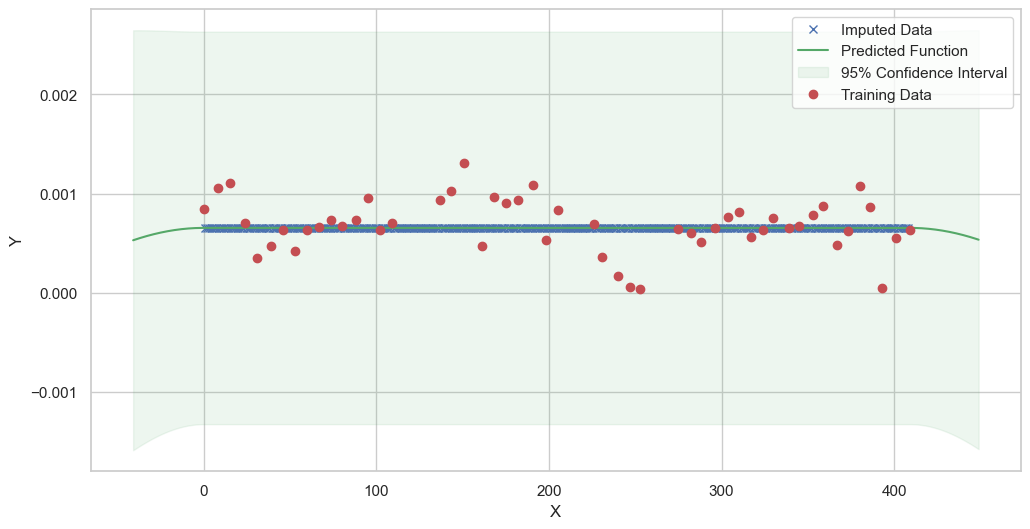

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Exponential'>
BIC: -500.21289609418716


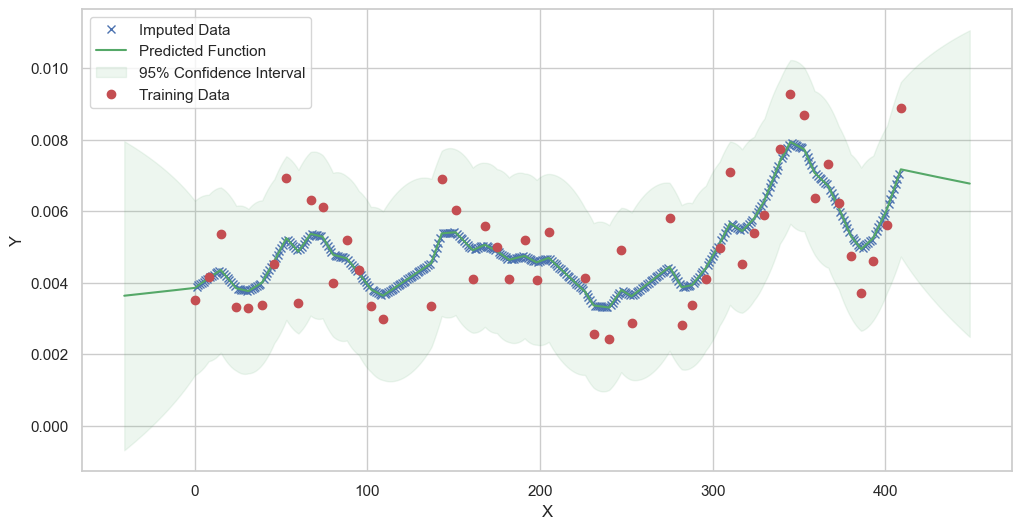

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern52'>
BIC: -469.1348556807966


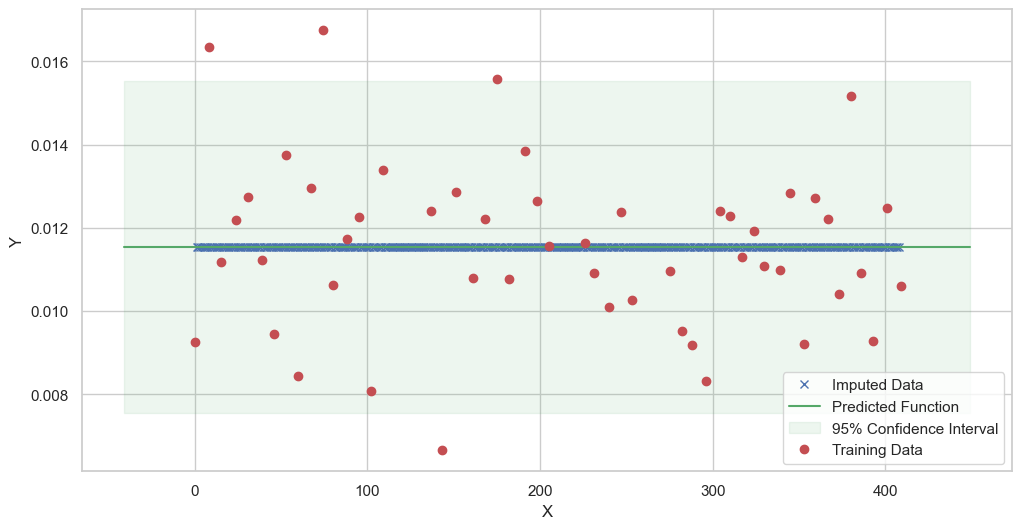

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern32'>
BIC: -381.04412693403106


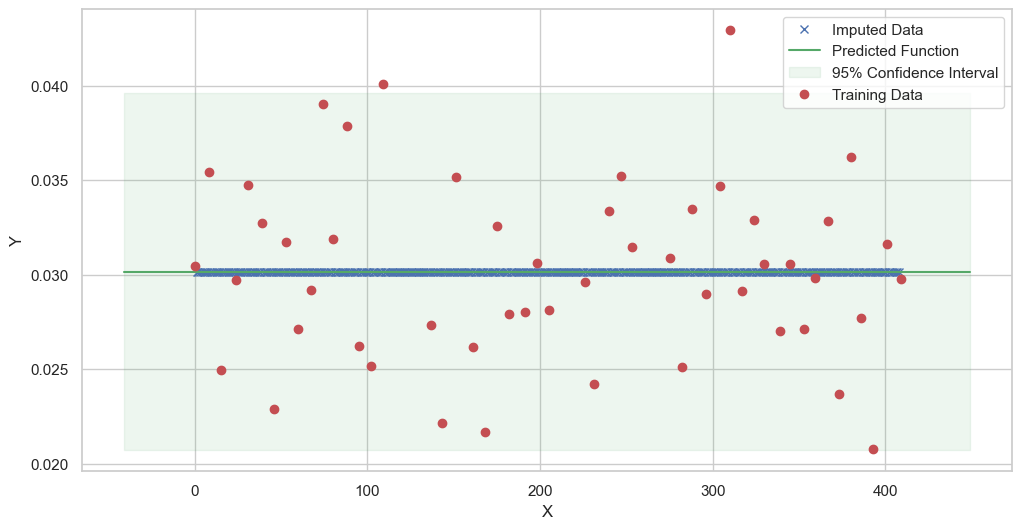

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern32'>
BIC: -465.3022570814244


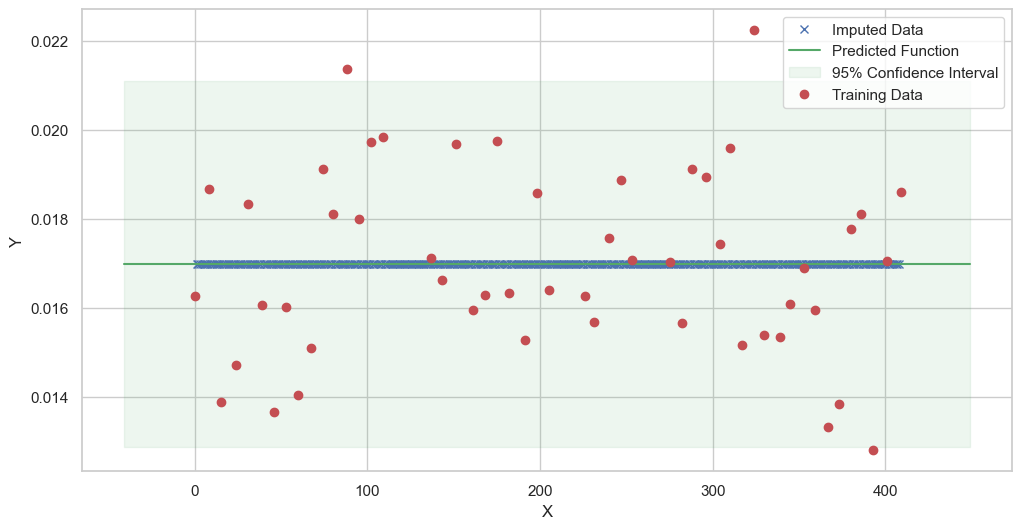

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Exponential'>
BIC: -419.91275591539477


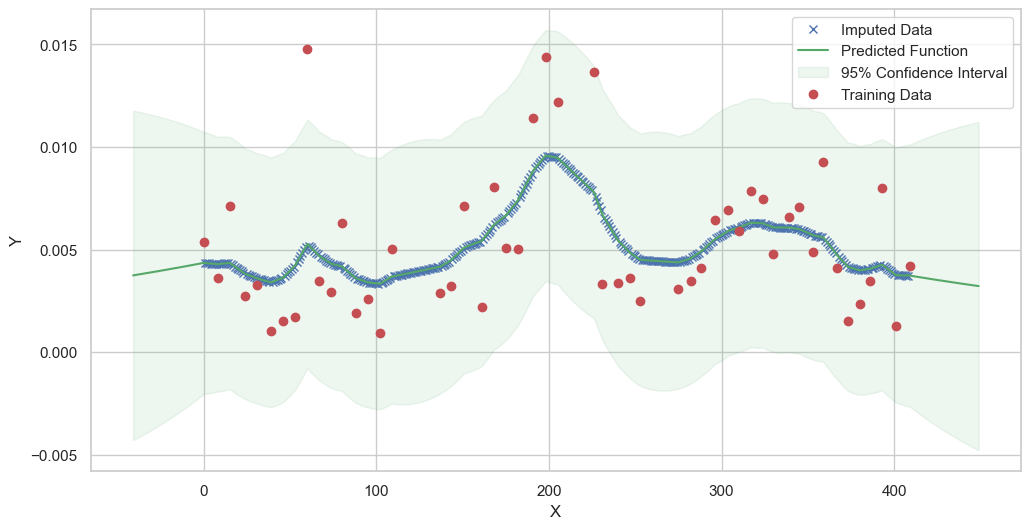

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -444.20360547540406


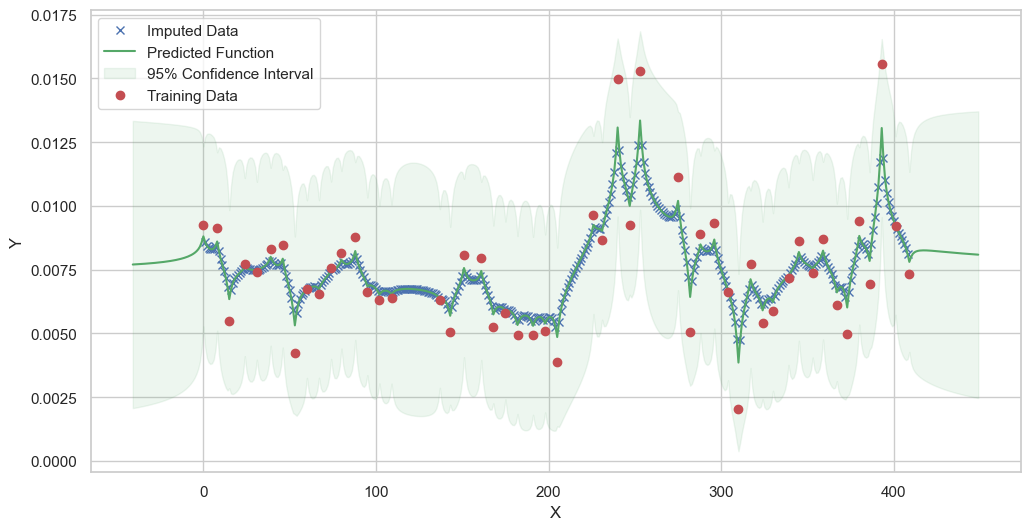

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -500.51396230556645


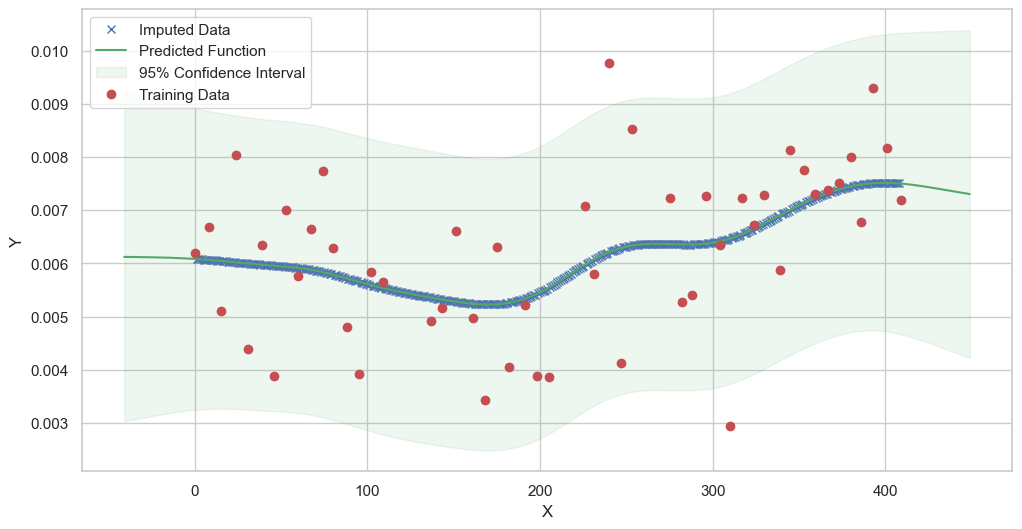

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Matern32'>
BIC: -382.3187023349286


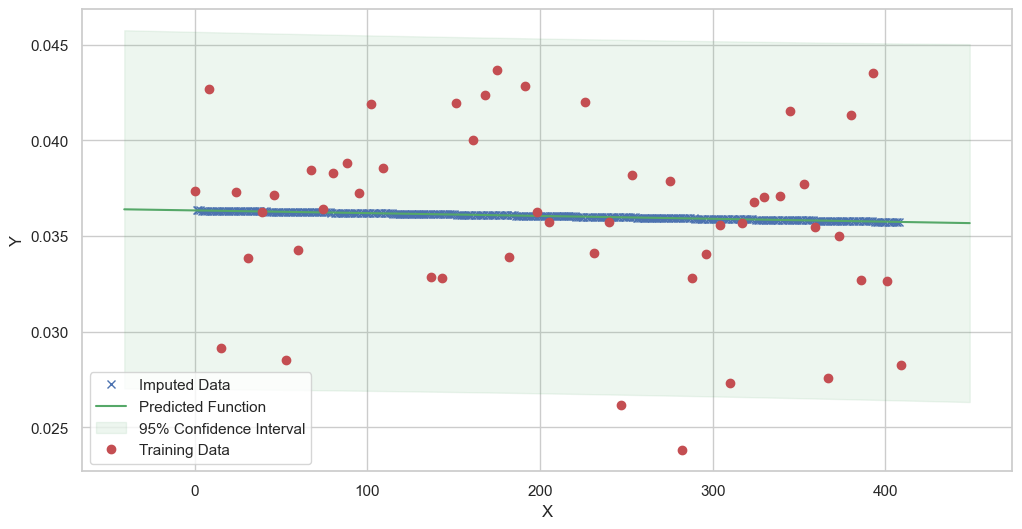

In [11]:
# do the imputation for each column (metabolite) in the dataset
# Copy the original dataset
new_dataset_complete = complete_dataMP_reset.copy()

for metabolite in dataL1_MP_complete.columns:
    # Impute the missing values for the current column
    imputed_data = GPImputer().impute_missing_values(
        complete_dataMP_reset, ['date'], [metabolite], metabolite
    )

    # Update the column in the new dataset with the imputed data
    new_dataset_complete[metabolite] = imputed_data[metabolite]

In [12]:
# Save the dataset (new_dataset_complete) to a csv file
new_dataset_complete.to_csv('MP_metabolite_imputed_dataV2.csv', index=False)